# Question 3.2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.metrics import mean_squared_error


### Part 3.2 (a)

In [99]:
cpi = pd.read_csv("/Users/stephenandrews/Downloads/MIT Schoolwork/Spring 2025/6.3732/6373Pset3/data/PriceStats_CPI.csv")

t10 = pd.read_csv("/Users/stephenandrews/Downloads/MIT Schoolwork/Spring 2025/6.3732/6373Pset3/data/T10YIE.csv")

t5 = pd.read_csv("/Users/stephenandrews/Downloads/MIT Schoolwork/Spring 2025/6.3732/6373Pset3/data/T5YIE.csv")

cpi['date'] = pd.to_datetime(cpi['date'])

clean_cpi = cpi.dropna(subset=['CPI'])


cpi.set_index('date', inplace=True)
monthly_cpi = cpi.resample('ME')['CPI'].first()
print(monthly_cpi)

monthly_cpi = monthly_cpi.dropna()
monthly_cpi = np.log1p(monthly_cpi)

print(monthly_cpi)

date
2008-07-31    100.00000
2008-08-31    100.52510
2008-09-30    100.12380
2008-10-31     99.98538
2008-11-30     98.97539
                ...    
2018-06-30    114.97750
2018-07-31    115.16080
2018-08-31    115.16850
2018-09-30    115.23250
2018-10-31          NaN
Freq: ME, Name: CPI, Length: 124, dtype: float64
date
2008-07-31    4.615121
2008-08-31    4.620306
2008-09-30    4.616346
2008-10-31    4.614976
2008-11-30    4.604924
                ...   
2018-05-31    4.749282
2018-06-30    4.753396
2018-07-31    4.754975
2018-08-31    4.755042
2018-09-30    4.755592
Freq: ME, Name: CPI, Length: 123, dtype: float64


Training period: 2008-07-31 to 2013-08-31
Testing period: 2013-09-30 to 2018-09-30
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(5)   Log Likelihood                 243.451
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Fri, 04 Apr 2025   AIC                           -472.902
Time:                        23:08:14   BIC                           -458.601
Sample:                    12-31-2008   HQIC                          -467.344
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0221      0.075      0.295      0.768      -0.125       0.169
CPI.L1         1.6945      0.122     13.834     

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/1440672237.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]  # start with the intercept
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/1440672237.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


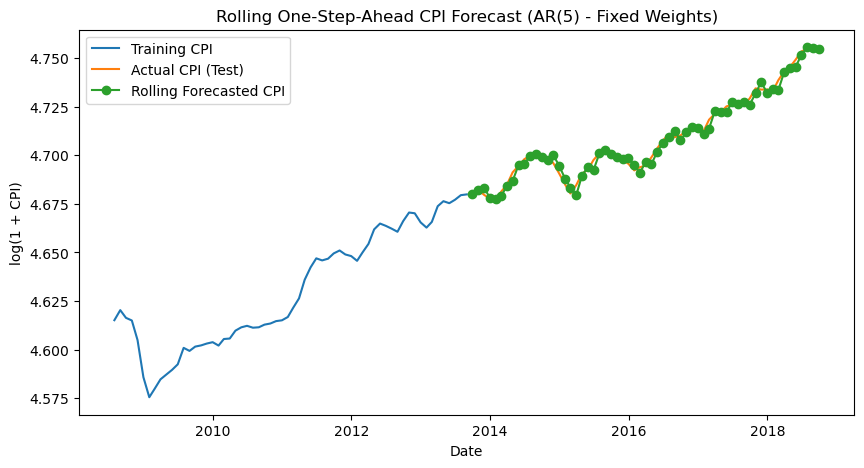

In [101]:
# Set the desired lag order here
lag_order = 5  # Change this number for AR(1), AR(2), etc.

# Assume 'monthly_cpi' is your pandas Series with a DatetimeIndex (month-end dates)

# Define the cutoff date for training and testing
cutoff_date = pd.Timestamp('2013-09-30')
train = monthly_cpi[monthly_cpi.index < cutoff_date]
test  = monthly_cpi[monthly_cpi.index >= cutoff_date]

print("Training period:", train.index.min().date(), "to", train.index.max().date())
print("Testing period:", test.index.min().date(), "to", test.index.max().date())

# Fit the AR model on the training data with the specified lag order
model = AutoReg(train, lags=lag_order, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

# Extract the fixed model parameters:
# model_fit.params[0] is the intercept, and model_fit.params[1] to model_fit.params[lag_order] are the AR coefficients.
params = model_fit.params

# Rolling one-step-ahead forecast using actual observed values for the lags
predictions = []
for t in test.index:
    yhat = params[0]  # start with the intercept
    # Loop over each lag from 1 to lag_order
    for lag in range(1, lag_order + 1):
        # Use MonthEnd to correctly obtain the previous month-end date for the given lag
        prev_time = t - pd.offsets.MonthEnd(lag)
        if prev_time in monthly_cpi.index:
            yhat += params[lag] * monthly_cpi.loc[prev_time]
        else:
            raise ValueError(f"Actual CPI value for {prev_time.date()} is not available.")
    predictions.append(yhat)

# Evaluate forecast performance using Mean Squared Error
mse = mean_squared_error(test, predictions)
print("\n MSE:", mse)

# Plot the actual CPI and the rolling forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training CPI')
plt.plot(test.index, test, label='Actual CPI (Test)')
plt.plot(test.index, predictions, label='Rolling Forecasted CPI', marker='o')
plt.title(f'Rolling One-Step-Ahead CPI Forecast (AR({lag_order}) - Fixed Weights)')
plt.xlabel('Date')
plt.ylabel('log(1 + CPI)')
plt.legend()
plt.show()



Fitting AR(1) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(1)   Log Likelihood                 243.154
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Fri, 04 Apr 2025   AIC                           -480.308
Time:                        23:15:26   BIC                           -473.976
Sample:                    08-31-2008   HQIC                          -477.827
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0405      0.090     -0.451      0.652      -0.217       0.136
CPI.L1         1.0090      0.019     51.984      0.000       0.971       1.047
           

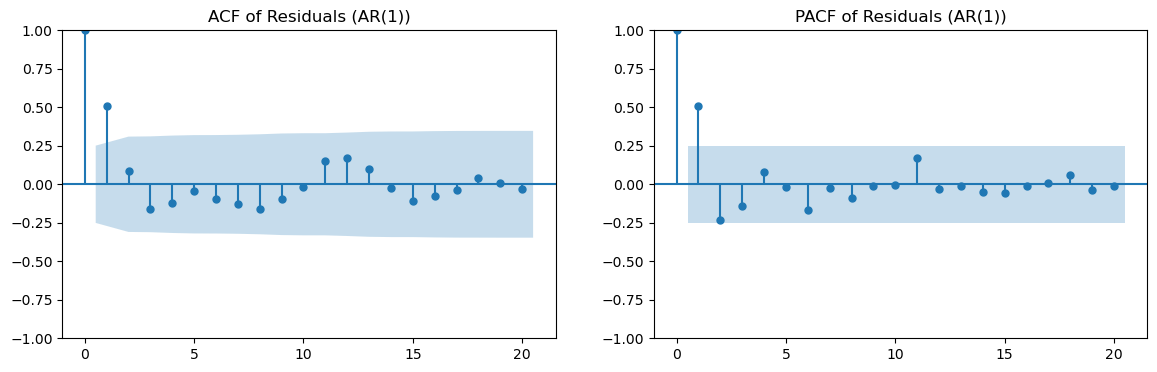

Rolling one-step forecast MSE for AR(1): 0.00001

Fitting AR(2) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 248.594
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Fri, 04 Apr 2025   AIC                           -489.188
Time:                        23:15:27   BIC                           -480.811
Sample:                    09-30-2008   HQIC                          -485.911
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0334      0.079      0.425      0.671      -0.121       0.188
CPI.L1         1.5208      0.109     13.8

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


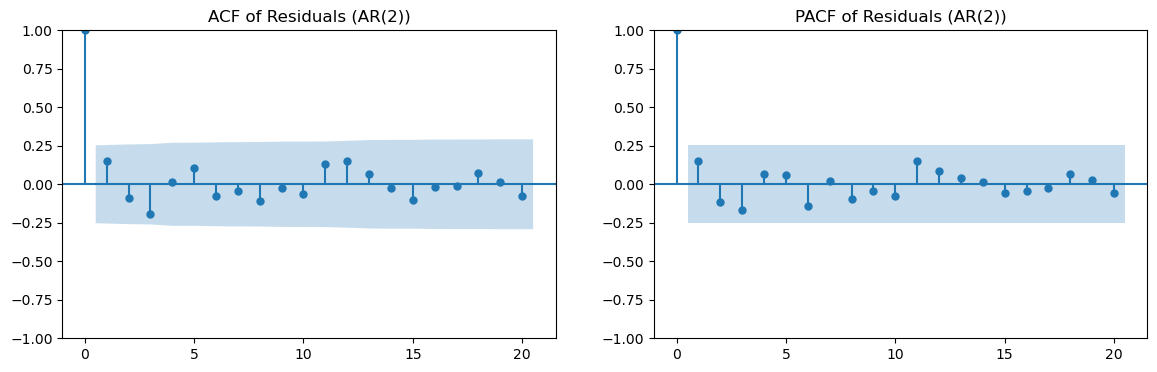

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


Rolling one-step forecast MSE for AR(2): 0.00001

Fitting AR(3) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(3)   Log Likelihood                 247.711
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Fri, 04 Apr 2025   AIC                           -485.421
Time:                        23:15:27   BIC                           -475.034
Sample:                    10-31-2008   HQIC                          -481.366
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.076      0.173      0.863      -0.136       0.163
CPI.L1         1.6729      0.122     13.6

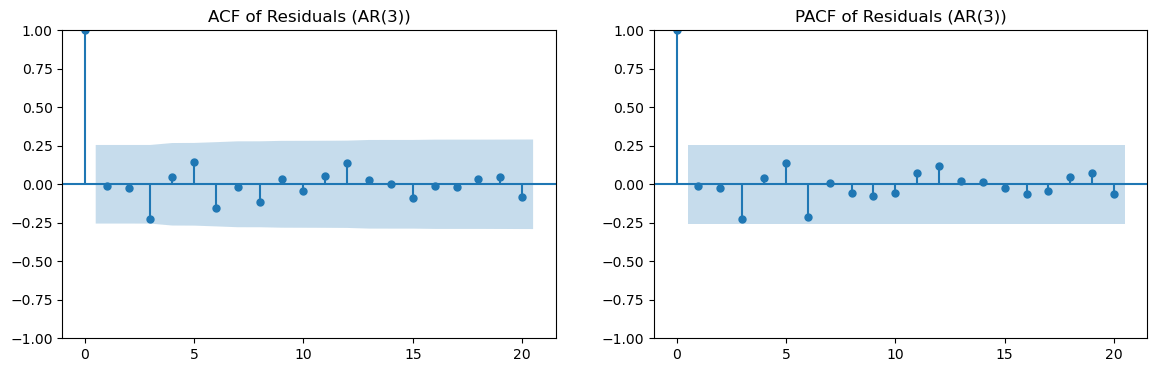

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


Rolling one-step forecast MSE for AR(3): 0.00001

Fitting AR(4) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(4)   Log Likelihood                 243.570
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Fri, 04 Apr 2025   AIC                           -475.139
Time:                        23:15:27   BIC                           -462.777
Sample:                    11-30-2008   HQIC                          -470.324
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.078     -0.056      0.956      -0.157       0.149
CPI.L1         1.6601      0.130     12.7

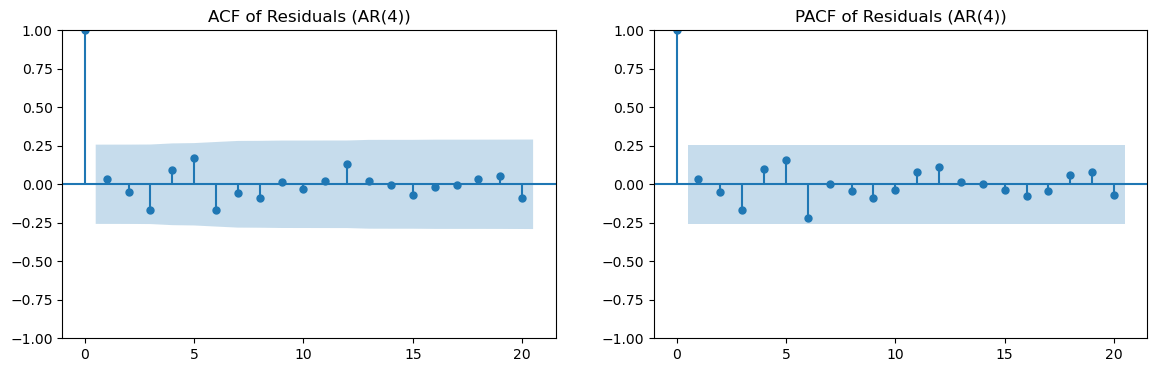

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


Rolling one-step forecast MSE for AR(4): 0.00001

Fitting AR(5) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(5)   Log Likelihood                 243.451
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Fri, 04 Apr 2025   AIC                           -472.902
Time:                        23:15:27   BIC                           -458.601
Sample:                    12-31-2008   HQIC                          -467.344
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0221      0.075      0.295      0.768      -0.125       0.169
CPI.L1         1.6945      0.122     13.8

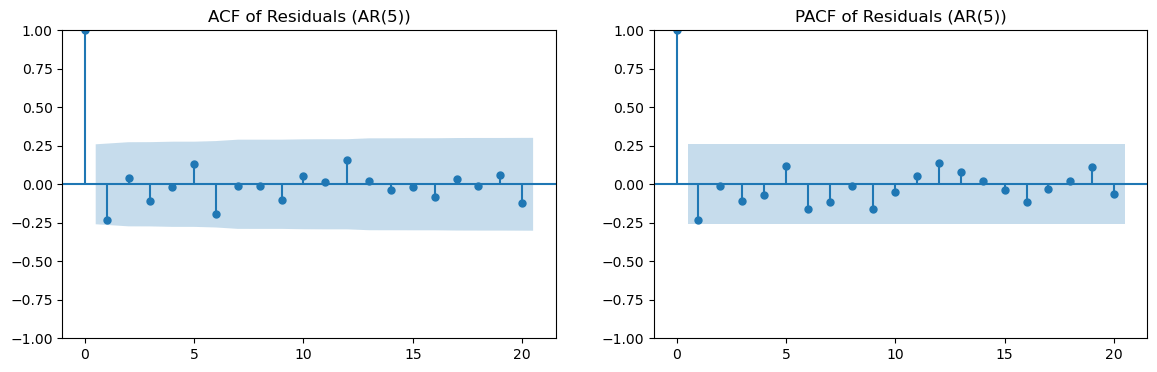

Rolling one-step forecast MSE for AR(5): 0.00001

Fitting AR(6) model on training data...
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(6)   Log Likelihood                 252.727
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Fri, 04 Apr 2025   AIC                           -489.455
Time:                        23:15:27   BIC                           -473.252
Sample:                    01-31-2009   HQIC                          -483.173
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0417      0.060      0.692      0.489      -0.076       0.160
CPI.L1         1.4631      0.104     14.0

/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


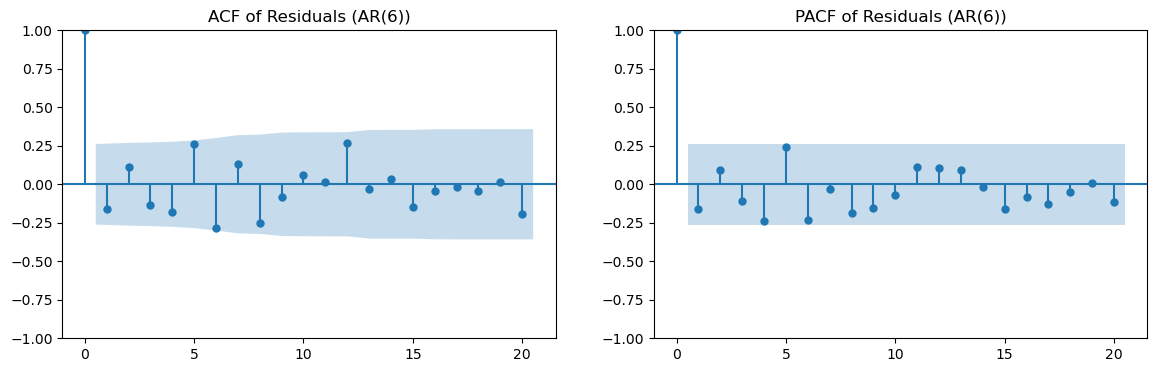

Rolling one-step forecast MSE for AR(6): 0.00001

Summary of Rolling One-Step Forecast MSE by AR order:
AR(1): MSE = 0.00001
AR(2): MSE = 0.00001
AR(3): MSE = 0.00001
AR(4): MSE = 0.00001
AR(5): MSE = 0.00001
AR(6): MSE = 0.00001


/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = params[0]
/var/folders/k7/r6jxg47s2152drbt5551gslm0000gn/T/ipykernel_95207/333401464.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat += params[lag] * monthly_cpi.loc[prev_time]


In [103]:
orders = range(1, 7)
forecast_mse = {}

for order in orders:
    print("\n" + "="*60)
    print(f"Fitting AR({order}) model on training data...")
    # Fit the AR model on training data with the current order
    model = AutoReg(train, lags=order, old_names=False)
    model_fit = model.fit()
    print(model_fit.summary())
    
    # Plot ACF and PACF of residuals to examine if additional lags are needed.
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(model_fit.resid, ax=ax[0], lags=20)
    ax[0].set_title(f'ACF of Residuals (AR({order}))')
    plot_pacf(model_fit.resid, ax=ax[1], lags=20)
    ax[1].set_title(f'PACF of Residuals (AR({order}))')
    plt.show()
    
    # Extract fixed model parameters (the weights trained on data before cutoff)
    params = model_fit.params

    # Compute rolling one-step forecasts on the test set.
    # We use the actual observed values for the lags (from monthly_cpi) without updating the model weights.
    forecast_indices = []
    predictions = []
    for t in test.index:
        # Initialize forecast with the intercept (params[0])
        yhat = params[0]
        valid = True
        # Loop over each lag from 1 to the current order
        for lag in range(1, order + 1):
            # Subtract lag months using MonthEnd to get the proper month-end date.
            prev_time = t - pd.offsets.MonthEnd(lag)
            if prev_time in monthly_cpi.index:
                yhat += params[lag] * monthly_cpi.loc[prev_time]
            else:
                valid = False
                break
        if valid:
            forecast_indices.append(t)
            predictions.append(yhat)
    
    # Align the forecasts with the corresponding actual test values.
    test_aligned = test[test.index.isin(forecast_indices)]
    if len(predictions) > 0 and len(test_aligned) > 0:
        mse = mean_squared_error(test_aligned, predictions)
        forecast_mse[order] = mse
        print(f"Rolling one-step forecast MSE for AR({order}): {mse:.5f}")
    else:
        print(f"Not enough test data to compute rolling forecast for AR({order}).")

# Display a summary of the forecast performance for each AR order.
print("\n" + "="*60)
print("Summary of Rolling One-Step Forecast MSE by AR order:")
for order, mse in forecast_mse.items():
    print(f"AR({order}): MSE = {mse:.5f}")